In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dask.array as da
import numpy as np
import pandas as pd
import plotly.express as px

from distributed import Client
from dask.array.routines import matmul_old, matmul
from dask.distributed import wait, progress
from dask.diagnostics import ResourceProfiler

In [3]:
from plotly import io as pio
pio.renderers.default = "png+plotly_mimetype"

In [4]:
def get_dask_cluster():
    # We use a single separate process to get fresh memory stats on
    # each client. GIL shouln't be a problem in this pipeline, also
    # old matmul runs out of memory when there is more processes to
    # split the memory (for larger inputs)
    return Client(n_workers=1)

In [5]:
def get_data(n: int, m: int, chunks=(1000, 250)):
    X = da.random.random(size=(n, m), chunks=chunks)
    Y = da.random.random(size=(n, 3), chunks=(chunks[0], -1))
    return X, Y

def perf_test(matmul_fn, X, Y):
    with ResourceProfiler() as prof:
        R = matmul_fn(X.T, Y)
        result = R.max().compute()
    return result, prof

def perf_suite(matmul_fn):
    results = []
    for n in 10**np.array([3, 3.5, 4, 4.5, 5, 5.5, 6]):
        m = 1000
        X, Y = get_data(int(n), m)
        _, prof = perf_test(matmul_fn, X, Y)
        results.append((m, n, prof.results))

    return pd.DataFrame([
        dict(m=r[0], n=r[1], mem=e.mem)
        for r in results
        for e in r[2]
    ])

In [6]:
# holds dask client
c = None

## Current matmul results

In [7]:
c and c.shutdown()
c = get_dask_cluster()
c

Client Scheduler: tcp://127.0.0.1:58653 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.36 GB


In [8]:
%%time
master_df = perf_suite(matmul_old)

CPU times: user 6.13 s, sys: 414 ms, total: 6.54 s
Wall time: 21.7 s


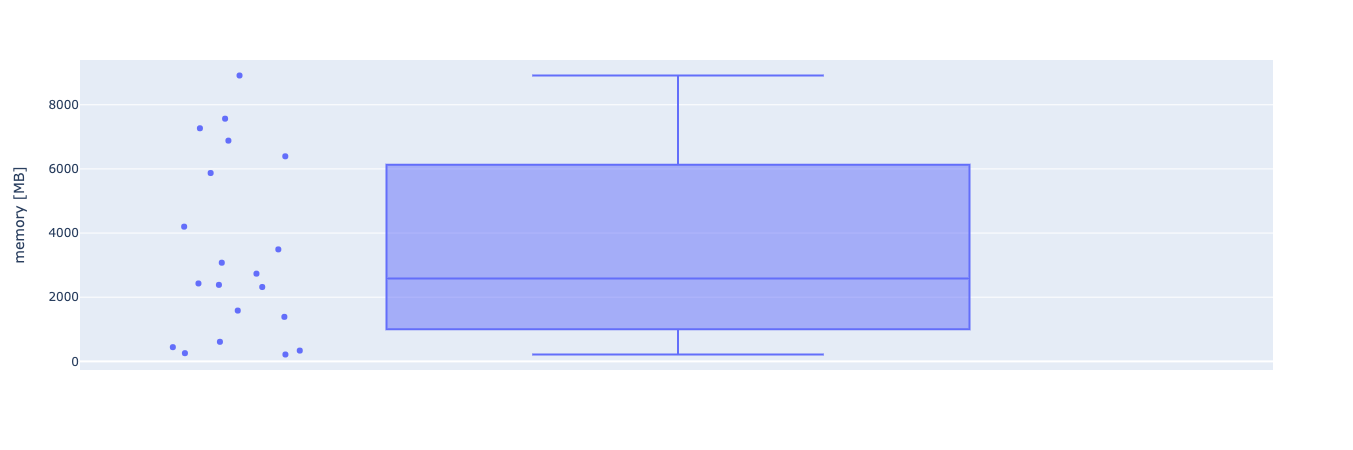

In [9]:
px.box(master_df, y="mem", points="all", labels={"mem": "memory [MB]"})

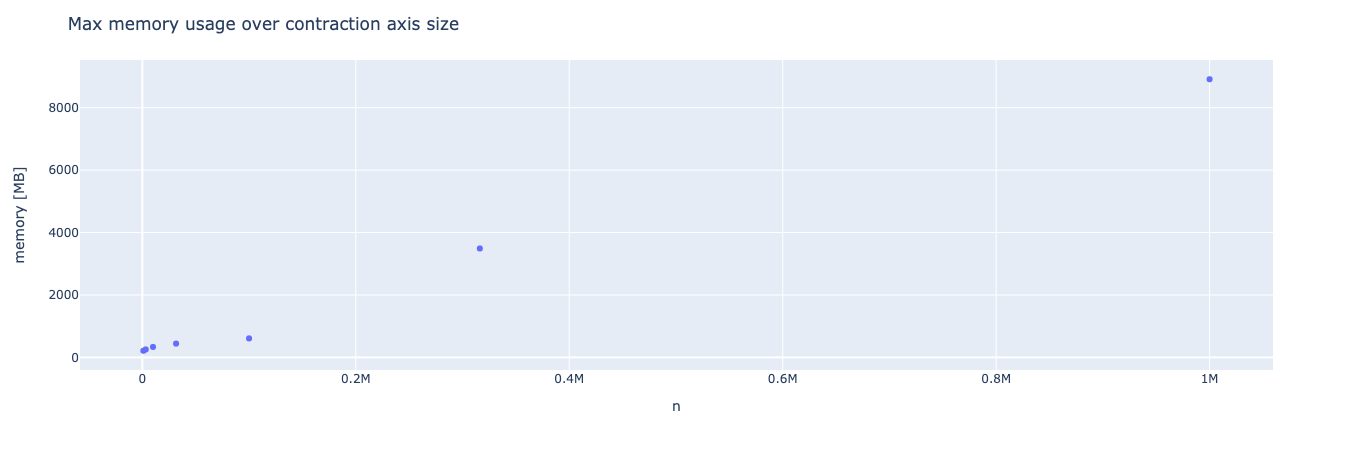

In [10]:
f = px.scatter(master_df.groupby(["n", "m"]).max().reset_index(drop=False),
               x="n", y="mem", labels={"mem": "memory [MB]"})
f.update_layout(title="Max memory usage over contraction axis size")

The memory footprint goes up as we increase the size of the input, this is due to the concatenated contraction happening in the blockwise, which forces more data to be materialized.

## New matmul results

In [11]:
# Restart the dask cluster to start from clean state
c and c.shutdown()
c = get_dask_cluster()
c

Client Scheduler: tcp://127.0.0.1:58957 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.36 GB


In [12]:
%%time
new_df = perf_suite(matmul)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


CPU times: user 28.4 s, sys: 4.31 s, total: 32.7 s
Wall time: 17.7 s


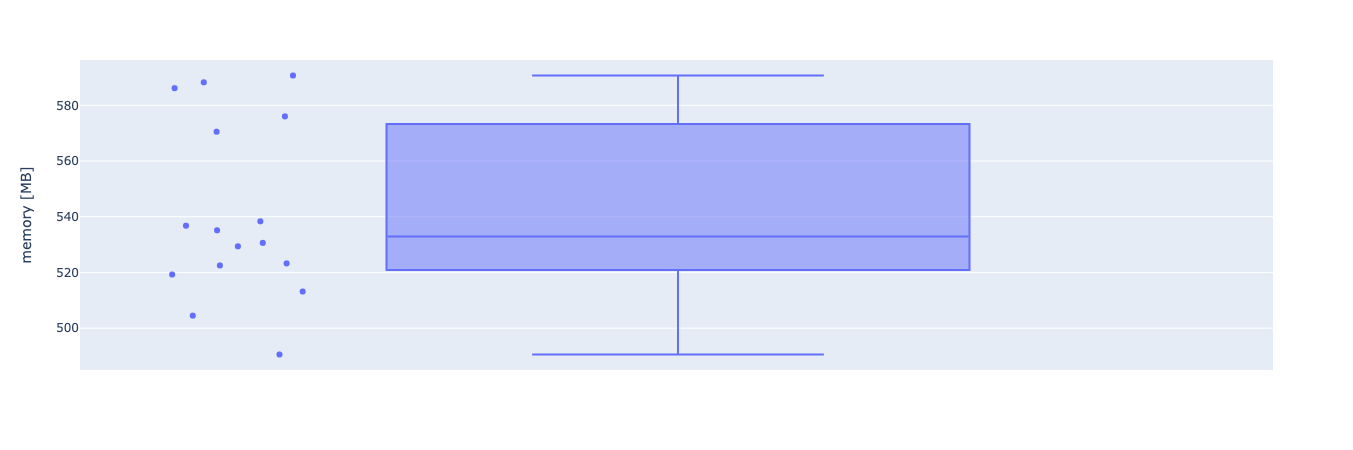

In [13]:
px.box(new_df, y="mem", points="all", labels={"mem": "memory [MB]"})

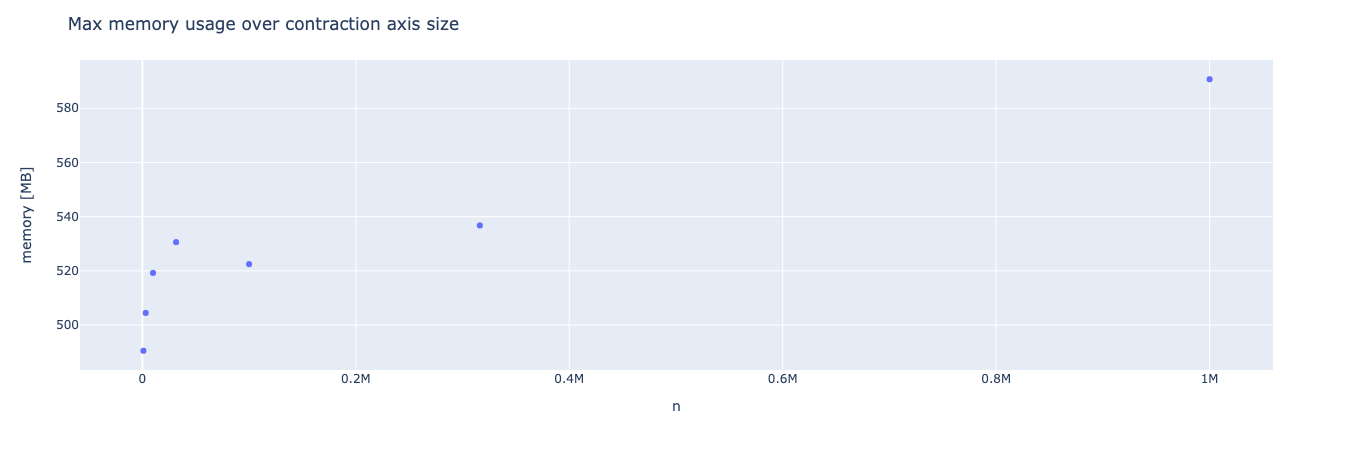

In [14]:
f = px.scatter(new_df.groupby(["n", "m"]).max().reset_index(drop=False),
               x="n", y="mem", labels={"mem": "memory [MB]"})
f.update_layout(title="Max memory usage over contraction axis size")

Memory usage is more or else stable despite increased input size.

## Large input

In [15]:
c and c.shutdown()
c = get_dask_cluster()
c

Client Scheduler: tcp://127.0.0.1:59076 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.36 GB


In [16]:
X, Y = get_data(n=10**7, m=1000)

In [17]:
%%time
resl7, perfl7 = perf_test(matmul, X, Y)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


CPU times: user 1min 11s, sys: 3.22 s, total: 1min 14s
Wall time: 2min 19s


In [18]:
%%time
resl7_old, perfl7_old = perf_test(matmul_old, X, Y)

CPU times: user 3min 27s, sys: 26.5 s, total: 3min 54s
Wall time: 17min 8s


In [19]:
assert np.allclose(resl7, resl7_old)

Same results, shorter execution time (2.5min vs 17min). The original matmul implementation has a higher memory footprint, which in this case forces spilling to disk (which is very exepnsive).